# CarND Object Detection Lab

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from PIL import Image
#from PIL import ImageDraw
#from PIL import ImageColor
import time
#from scipy.stats import norm
import os

%matplotlib inline
plt.style.use('ggplot')
os.chdir('C:\\Users\\Silvan\\Documents\\Udacity_Nanodegree\\Project 9_Autonomous Vehicle\\Capstone')

## Prepare dataset for training and validation

In [2]:
import csv
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
"""# Read in info about raw data from car camera and safe in df (pd.DataFrame format)
with open('images/images/classes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    content = list()
    for row in spamreader:
        #print(', '.join(row))
        row[0] = 'images/images/'+row[0]
        content.append(row)

with open('images/images2/classes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        row[0] = 'images/images2/'+row[0]
        content.append(row)
#df = pd.DataFrame(data=content, columns=["path", "class"])
#df["class"].value_counts(),df.describe()
content = np.array(content)"""

In [3]:
content = list()
with open('images/signlabels.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        content.append(row)
content = np.array(content)

In [4]:
def load_content(content, verbose=1):
    images = list()
    labels = list()
    paths = list()
    for path, label in content:
        paths.append(path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        if label == "green":
            labels.append(2)
        elif label == "red":
            labels.append(0)
        elif label == "yellow":
            labels.append(1)
        else:
            labels.append(4)
            print("[ERROR] Label of image ", path, " neither red, yellow, or green!")
    images = np.asarray(images)
    labels = np.asarray(labels)
    if verbose ==1:
        return images, labels
    elif verbose ==2:
        return images, labels, paths


images, labels = load_content(content)
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

(293, 600, 800, 3) uint8
(293,) int32


## Object Detection Inference

In this part of the lab traffic light detection is using pretrained object detection models. The source of the used models was the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), where one can download the relevant models.

In [32]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
#SSD_GRAPH_FILE = 'models/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
#RFCN_GRAPH_FILE = 'models/rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
#FASTER_RCNN_GRAPH_FILE = 'models/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'
#FASTER_RCNN_KITTI_FILE = 'models/faster_rcnn_resnet101_kitti_2018_01_28/frozen_inference_graph.pb'
SSDLITE_GRAPH_FILE = 'models/ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [33]:
# Colors (one for each class)
#cmap = ImageColor.colormap
#print("Number of colors =", len(cmap))
#COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#
def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def filter_boxes1(min_score, search_class, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score and classes[i] == search_class:
            idxs.append(i)
            break
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image_path, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [34]:
def detect_tl(image, sess):
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.45
    search_class = 10
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes1(confidence_cutoff, search_class, boxes, scores, classes)


    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.shape[1], image.shape[0]
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    #draw_boxes(path, box_coords, classes)

    # Crop image to detected traffic light
    coords = np.squeeze(box_coords).astype(int)
    return coords

Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [35]:
# Change path for the moment
model_path = 'C://Users//Silvan//Documents//Udacity_Nanodegree//Project 9_Autonomous Vehicle//Object-Detection-Lab//CarND-Object-Detection-Lab'
actual_path = os.getcwd()
os.chdir(model_path)

#detection_graph = load_graph(SSD_GRAPH_FILE)
#detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)
#detection_graph = load_graph(FASTER_RCNN_KITTI_FILE)
detection_graph = load_graph(SSDLITE_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Change path back to former working directory
os.chdir(actual_path)

Run detection and classification on a sample image.

In [ ]:
# Load a sample image.

image1 = './images/images/frame0140.jpg'
image2 = './images/images/frame0116.jpg'
image3 = './images/images/frame0001.jpg'
image4 = './images/frame0092.jpg'
#image4 = './images/image003.jpg' #flowers
images = [image1, image2, image3, image4]

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    for path in images:
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect traffic light in image
        coords = detect_tl(image, sess)
        print(coords)
        if coords.size > 0:
            print("Trueee")
        # Show detected traffic light only
        image1 = cv2.resize(image[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
        plt.figure(figsize=(2, 2))
        plt.imshow(image1)
        
        # Show complete image with annotated boxes
        #plt.figure(figsize=(6,4))
        #plt.imshow(image)

## SKIP!! Make training data for classifier (not necessary to run again!!)

In [ ]:
new_content = list()
error_counter = 0
total_counter = 0
times = list()
base_path = "images/sign_only"
os.mkdir(base_path)
os.mkdir(base_path+"/images")
os.mkdir(base_path+"/images2")
with tf.Session(graph=detection_graph) as sess:                
    for path, label in content:
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect traffic light in image and record time needed for detection
        t0 = time.time()
        coords = detect_tl(image, sess)
        t1 = time.time()
        times.append((t1 - t0) * 1000)
        
        # Show detected traffic light only
        try:
            image1 = cv2.resize(image[coords[0]:coords[2], coords[1]:coords[3]], (16,32))

            # Saving the image 
            filename = base_path+path[path.find("/"):path.find(".jpg")]+"_sign_only.jpg"
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            cv2.imwrite(filename, image1)
            new_content.append([filename, label])
        except:
            print("[Error] Detector could not find a sign in image ", path)
            error_counter +=1
        total_counter +=1
        
print("TL_Detector did not detect ", error_counter, " of ", total_counter, " images -> ",
      np.around(100*error_counter/total_counter, decimals=1), " %")

times = np.array(times)
# Save info in seperate file
with open(base_path+'/signlabels_sign_only.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|')
    spamwriter.writerows(new_content)

### Visualize needed time for detection

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Print basic info about times
print("Mean:", np.mean(times), "ms\nMedian:", np.median(times), "ms\nFirst run:", times[0],
      "ms\nFastest run:", min(times), "ms")
# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

## Summary for model comparison:

Test was made on an old laptop without activated GPU, so run times can not be taken absolutely but must be seen as relative measurement for comparison.

---
#### Model1: ssd_mobilenet_v1_coco_11_06_2017
Did not detect traffic signs on *21.5%* of the training images.
Needed *245.86 ms* (median) and *283.43 ms* (mean) for one run.
First run needed *6738 ms*.

#### Model2: ssdlite_mobilenet_v2_coco_2018_05_09
Did not detect traffic signs on *17.1%* of the training images.
Needed *152.91 ms* (median) and *176.06 ms* (mean) for one run.
First run needed *5640 ms*.

#### Model3: faster_rcnn_resnet101_kitti_2018_01_28
Needed far longer with 7578 ms (median) per run. So it is about 50 times slower than model2 on this machine which is far to slow and the rate of detection is not relevant as this model is definitely worse than model2.

#### Model4: faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017
Needed even far longer with 50147 ms (median) per run. So it is about 328 times slower than model2 on this machine which is far to slow and the rate of detection is not relevant as this model is definitely worse than model2.

---

**It is obvious that model2 seems to be best suited for the traffic light detection task.**

# TL_Classifier
## Load training data for tl_classifier

In [5]:
new_content = list()
#filename = 'images/sign_only/signlabels_sign_only.csv'
filename = 'images/signlabels_sign_only.csv'
with open(filename, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        new_content.append(row)
new_content = np.array(new_content)

# Load images with signs only for training
images, labels = load_content(new_content)

print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

(243, 32, 16, 3) uint8
(243,) int32


## Build tl_Classifier model

In [6]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.optimizers import adam
from keras.utils.data_utils import Sequence
from keras.utils import plot_model, to_categorical
from keras import backend as K
#K.set_learning_phase(1)

Using TensorFlow backend.


In [7]:
# ================================================================================
# standard CNN model
def build_model():
    '''
    Build CNN model for light color classification
    '''
    num_classes = 3
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same',
                     input_shape=(32,16,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.summary()
    plot_model(model, to_file='TL_handling//tl_classifier_model.png')

    return model

In [8]:
#K.set_learning_phase(1)
seq_model = build_model()
seq_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Load data and one hot encode
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 16, 8)         224       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 7, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 5, 32)         4640      
_________________________________________________________________
activation_3 (Activation)    (None, 13, 5, 32)         0         
__________

In [9]:
seq_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, shuffle=True, validation_data=(X_test, y_test))

Train on 194 samples, validate on 49 samples
Epoch 1/10
194/194 [==============================] - 0s - loss: 3.1354 - acc: 0.7320 - val_loss: 0.0209 - val_acc: 0.9796
Epoch 2/10
194/194 [==============================] - 0s - loss: 0.0506 - acc: 0.9897 - val_loss: 0.0753 - val_acc: 0.9796
Epoch 3/10
194/194 [==============================] - 0s - loss: 0.0110 - acc: 0.9948 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4/10
194/194 [==============================] - 0s - loss: 2.3609e-05 - acc: 1.0000 - val_loss: 2.8875e-04 - val_acc: 1.0000
Epoch 5/10
194/194 [==============================] - 0s - loss: 1.7238e-05 - acc: 1.0000 - val_loss: 1.4844e-04 - val_acc: 1.0000
Epoch 6/10
194/194 [==============================] - 0s - loss: 1.6855e-04 - acc: 1.0000 - val_loss: 1.2722e-04 - val_acc: 1.0000
Epoch 7/10
194/194 [==============================] - 0s - loss: 5.0708e-06 - acc: 1.0000 - val_loss: 1.8420e-04 - val_acc: 1.0000
Epoch 8/10
194/194 [==============================] - 0s - los

## Save keras model

In [10]:
def save_keras_model(save_model, path):
    """Saves keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

In [11]:
model_path = 'TL_handling//tl_classifier_'
save_keras_model(seq_model, 'TL_handling//tl_classifier_')

## Load pretrained model

In [12]:
def load_model(path):
    model = model_from_json(open(path + '.json','r').read())
    model.load_weights(path + '.h5')
    return model

In [13]:
model_path = 'TL_handling//tl_classifier_model'
seq_model = load_model(model_path)
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 16, 8)         224       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 7, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 5, 32)         4640      
_________________________________________________________________
activation_3 (Activation)    (None, 13, 5, 32)         0         
__________

### Convert keras model to tensorflog graph

In [14]:
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

#from keras.models import load_model
model = load_model(model_path)
print(model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

[<tf.Tensor 'activation_5_2/Softmax:0' shape=(?, 3) dtype=float32>]
[<tf.Tensor 'conv2d_1_input_2:0' shape=(?, 32, 16, 3) dtype=float32>]


In [15]:
#from keras import backend as K
#import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 55 variables.
Converted 55 variables to const ops.


In [16]:
# Save to ./model/tf_model.pb
CLASSIFIER_GRAPH_FILE = 'TL_handling/tl_classifier_tf_model.pb'
model_path = 'TL_handling'
tf.train.write_graph(frozen_graph, model_path,"tl_classifier_tf_model.pb", as_text=False)

'TL_handling\\tl_classifier_tf_model.pb'

## Load Graph model

In [26]:
classifier_graph = load_graph(CLASSIFIER_GRAPH_FILE)
# Get output tensor of classifier model
output_tensor = classifier_graph.get_tensor_by_name('activation_5_2/Softmax:0')

# Get input tensor of classifier model
input_tensor = classifier_graph.get_tensor_by_name('conv2d_1_input_2:0')

# Test on sample
## With tf model

('Pred: ', 1, 'True: ', 1, ' [0: red, 1:yellow, 2: green]')

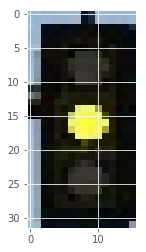

In [28]:
take_ID = True # Visu image from dataset
times = list()
time_labels = list()

if take_ID:
    # Visualize Image from dataset
    ID = 80 #yellow
    #ID = 40 #red
    #ID = 150 #green
    img = images[ID]
    label = labels[ID]
    plt.imshow(img)
else:
    # Or load something else
    time_labels.append('start absolute')
    times.append(time.time())   ######## time1: start absolute
    label = "?"
    path = "images/image002.jpg" #001, 002, 009
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    # Detect traffic light in image
    time_labels.append('start of detection')
    times.append(time.time())   ######## time2: start of detection
    with tf.Session(graph=detection_graph) as sess:
        coords = detect_tl(img, sess)
    time_labels.append('end of detection')
    times.append(time.time())   ######## time3: end of detection
    # Show detected traffic light only
    img = cv2.resize(img[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
    #plt.figure(figsize=(2, 2))
    #plt.imshow(img)

image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
time_labels.append('end of preparation for classification')
times.append(time.time())   ######## time4: end of preparation for classification
#pred_label = np.argmax(seq_model.predict(image_np)[0])
with tf.Session(graph=classifier_graph) as sess1:
    predictions = sess1.run(output_tensor, {input_tensor: image_np})
    pred_label = np.argmax(predictions[0])
#time_labels.append('end of classification')
times.append(time.time())   ######## time5: end of classification
"Pred: ",pred_label, "True: ", label, " [0: red, 1:yellow, 2: green]"

## With keras model

In [40]:
import sys
sys.version

'3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]'

In [41]:
tf.__version__

'1.3.0'

('Pred: ', 1, 'True: ', 1, ' [0: red, 1:yellow, 2: green]')

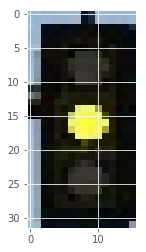

In [29]:
take_ID = True # Visu image from dataset
times = list()
time_labels = list()

if take_ID:
    # Visualize Image from dataset
    ID = 80 #yellow
    #ID = 40 #red
    #ID = 150 #green
    img = images[ID]
    label = labels[ID]
    plt.imshow(img)
else:
    # Or load something else
    time_labels.append('start absolute')
    times.append(time.time())   ######## time1: start absolute
    label = "?"
    path = "images/image002.jpg" #001, 002, 009
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    # Detect traffic light in image
    time_labels.append('start of detection')
    times.append(time.time())   ######## time2: start of detection
    with tf.Session(graph=detection_graph) as sess:
        coords = detect_tl(img, sess)
    time_labels.append('end of detection')
    times.append(time.time())   ######## time3: end of detection
    # Show detected traffic light only
    img = cv2.resize(img[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
    #plt.figure(figsize=(2, 2))
    #plt.imshow(img)


image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
time_labels.append('end of preparation for classification')
times.append(time.time())   ######## time4: end of preparation for classification
pred_label = np.argmax(seq_model.predict(image_np)[0])
time_labels.append('end of classification')
times.append(time.time())   ######## time5: end of classification
"Pred: ",pred_label, "True: ", label, " [0: red, 1:yellow, 2: green]"

### Test on all images in dataset

In [30]:
tf.__version__

'1.3.0'

In [36]:
# Init variables
error_counter = 0
total_counter = 0
miss_counter = 0
label_names = ["red", "yellow", "green"]
delta_times_total = list()

# Load full images
images, labels, paths = load_content(content, verbose=2)
print("Shape of dataset: ", images.shape, images.dtype)
print("Shape of labels: ", labels.shape, labels.dtype)

#with tf.Session(graph=detection_graph) as sess:
sess = tf.Session(graph=detection_graph)
sess1 = tf.Session(graph=classifier_graph)
for ID in range(len(images[:10])):
    delta_times = list()
    t0 = time.time()
    image = images[ID]
    label = labels[ID]

    # Try to detect traffic light
    coords = detect_tl(image, sess)

    # Save needed time
    t1 = time.time()
    dt = t1-t0
    delta_times.append(dt) #Detection
    try:
        # Show detected traffic light only
        img = cv2.resize(image[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
        image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
         # Save needed time
        t2 = time.time()
        dt = t2-t1
        delta_times.append(dt) #Preparation
        pred_label = 4
        """with tf.Graph().as_default():
            with tf.Session() as sess1:
                K.set_session(sess1)                   
                seq_model = load_model(model_path)
                pred_label = np.argmax(seq_model.predict(image_np)[0])"""
        #with tf.Session(graph=classifier_graph) as sess1:
        predictions = sess1.run(output_tensor, {input_tensor: image_np})
        pred_label = np.argmax(predictions[0])
        # Save needed time
        t3 = time.time()
        dt = t3-t2
        delta_times.append(dt) # Prep Classification

        if pred_label != label:
            miss_counter += 1
            print("[ERROR] Classifier misclassified image ", paths[ID], " with ", label_names[label], " (true) as ", label_names[pred_label], " (pred)")

    except:
        print("[Error] Detector could not find a sign in image ", paths[ID])
        error_counter +=1
    total_counter +=1
    delta_times_total.append(delta_times)
sess.close()
sess1.close()
print("TL_Detector did not detect ", error_counter, " of ", total_counter, " images -> ",
  np.around(100*error_counter/total_counter, decimals=1), " %")
print("TL_Classifier missclassified ", miss_counter, " of ", total_counter-error_counter, " images -> ",
  np.around(100*miss_counter/(total_counter-error_counter), decimals=1), " %")

Shape of dataset:  (293, 600, 800, 3) uint8
Shape of labels:  (293,) int32
TL_Detector did not detect  0  of  10  images ->  0.0  %
TL_Classifier missclassified  0  of  10  images ->  0.0  %


### Visualize times

In [37]:
a = delta_times_total
b = np.zeros([len(a),len(max(a,key = lambda x: len(x)))])
for i,j in enumerate(a):
    b[i][0:len(j)] = j
time_deltas = np.hstack((b,b.sum(axis=1).reshape(-1,1)))

array([0.26984596, 0.        , 0.00199807, 0.2713443 ])

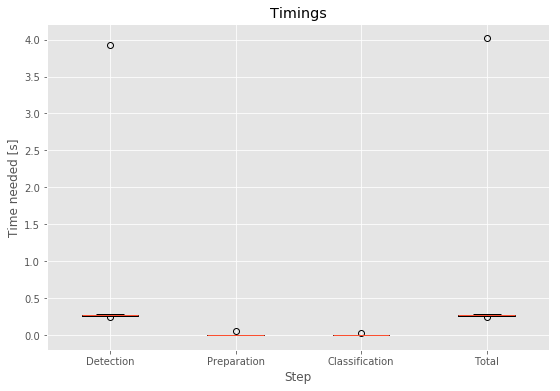

In [38]:
#time_deltas = np.array(delta_times_total)
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Timings")
plt.ylabel('Time needed [s]')
plt.xlabel('Step')
#plt.ylim([0.000997,0.001005])
plt.style.use('fivethirtyeight')
bp = ax.boxplot(time_deltas)

labels = ["Detection", "Preparation", "Classification", "Total"]
plt.xticks([i+1 for i in range(len(labels))], labels)
np.median(time_deltas, axis=0)